In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [4]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [5]:
from src.utils import get_weeks
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[52:]
week_labels = get_weeks(day_from=20160104, num_weeks=121)[96:]
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[104:]

In [6]:
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)
customer   = pd.read_csv(RAW/'Customer.csv', low_memory=False)
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)

In [7]:
print(week_labels)

[20171106, 20171113, 20171120, 20171127, 20171204, 20171211, 20171218, 20171225, 20180101, 20180108, 20180115, 20180122, 20180129, 20180205, 20180212, 20180219, 20180226, 20180305, 20180312, 20180319, 20180326, 20180402, 20180409, 20180416, 20180423]


In [8]:
from src.utils import make_val_set

In [9]:
PROCESSED

PosixPath('data/processed')

In [10]:
%%time
train = pd.DataFrame()
for name in week_labels[:-1]:
    train = pd.concat([train, pd.read_feather(PROCESSED/f'week_{name}_SVD_diffscount.feather')])

CPU times: user 3min 35s, sys: 1min 51s, total: 5min 27s
Wall time: 5min 51s


In [11]:
test = pd.read_feather(PROCESSED/f'week_{week_labels[-1]}_SVD_diffscount.feather')

In [12]:
train.head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,DaysSinceBuySell,DaysSinceTransaction,DaysSinceCustomerActivity,DaysSinceBondActivity,DaysCountBuySell,DaysCountTransaction,DaysCountCustomerActivity,DaysCountBondActivity,SVD_CustomerBias,SVD_IsinBuySellBias,SVD_Recommend,SVD_CustomerFactor00,SVD_CustomerFactor01,SVD_CustomerFactor02,SVD_CustomerFactor03,SVD_CustomerFactor04,SVD_CustomerFactor05,SVD_CustomerFactor06,SVD_CustomerFactor07,SVD_CustomerFactor08,SVD_CustomerFactor09,SVD_CustomerFactor10,SVD_CustomerFactor11,SVD_CustomerFactor12,SVD_CustomerFactor13,SVD_CustomerFactor14,SVD_IsinBuySellFactor00,SVD_IsinBuySellFactor01,SVD_IsinBuySellFactor02,SVD_IsinBuySellFactor03,SVD_IsinBuySellFactor04,SVD_IsinBuySellFactor05,SVD_IsinBuySellFactor06,SVD_IsinBuySellFactor07,SVD_IsinBuySellFactor08,SVD_IsinBuySellFactor09,SVD_IsinBuySellFactor10,SVD_IsinBuySellFactor11,SVD_IsinBuySellFactor12,SVD_IsinBuySellFactor13,SVD_IsinBuySellFactor14,Year,Month,Day,Sector,Subsector,Region_x,Country,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region_y,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,BondDuration,BondRemaining,BondLife
0,20171106,0,21856,Buy,0.0,859,859,41,17,0,0,26,46,0.145856,0.066204,0.514251,-0.029115,0.016691,-0.056704,0.096195,0.045666,0.092239,0.08126,0.055171,-0.115695,-0.020836,-0.071208,0.011179,0.004409,0.016432,0.023712,0.012533,0.111760,0.005203,0.036013,0.046625,0.177593,0.047611,0.083235,-0.051471,0.006236,-0.021289,0.080423,0.056338,0.122781,-0.062886,2017,17,6,Asset Managers & Hedge Funds,Independent Asset Manager,Asia Pacific,HONG KONG,1930,20190114,20140114,SEN,USD,FLOW LOCAL MARKET,ASIA-TOKYO,ASIA MARKET MAKING,ASIA HIGH YIELD,ASIA HIGH YIELD,14,Financial,Real Estate Oper/Develop,Euro-dollar,600000000.0,FIXED,1826,434,1392
1,20171106,0,21856,Sell,0.0,859,859,41,17,0,0,26,46,0.145856,0.054329,0.515428,-0.029115,0.016691,-0.056704,0.096195,0.045666,0.092239,0.08126,0.055171,-0.115695,-0.020836,-0.071208,0.011179,0.004409,0.016432,0.023712,0.050487,-0.006822,0.050556,0.100922,0.190385,0.112586,0.102837,0.077350,-0.131995,-0.041197,0.008692,0.154851,-0.077626,0.028060,-0.025874,2017,17,6,Asset Managers & Hedge Funds,Independent Asset Manager,Asia Pacific,HONG KONG,1930,20190114,20140114,SEN,USD,FLOW LOCAL MARKET,ASIA-TOKYO,ASIA MARKET MAKING,ASIA HIGH YIELD,ASIA HIGH YIELD,14,Financial,Real Estate Oper/Develop,Euro-dollar,600000000.0,FIXED,1826,434,1392
2,20171106,0,24944,Buy,0.0,859,859,41,3,0,0,26,69,0.145856,0.269019,0.717230,-0.029115,0.016691,-0.056704,0.096195,0.045666,0.092239,0.08126,0.055171,-0.115695,-0.020836,-0.071208,0.011179,0.004409,0.016432,0.023712,-0.083098,-0.104140,-0.195715,-0.057268,0.241214,0.092401,0.040741,0.042378,-0.137947,0.155237,0.036170,0.030057,0.051076,-0.056409,-0.017747,2017,17,6,Asset Managers & Hedge Funds,Independent Asset Manager,Asia Pacific,HONG KONG,1333,20230817,20160817,SEN,USD,FLOW LOCAL MARKET,ASIA-TOKYO,ASIA MARKET MAKING,ASIA HIGH YIELD,ASIA HIGH YIELD,0,Financial,Property/Casualty Ins,Euro-dollar,590000000.0,FIXED,2556,2110,446
3,20171106,0,24944,Sell,0.0,859,859,41,3,0,0,26,69,0.145856,0.384511,0.806818,-0.029115,0.016691,-0.056704,0.096195,0.045666,0.092239,0.08126,0.055171,-0.115695,-0.020836,-0.071208,0.011179,0.004409,0.016432,0.023712,-0.063905,0.071768,-0.066420,-0.076050,-0.025910,0.096641,-0.007377,0.166042,-0.052101,-0.057384,0.100283,0.024377,0.001089,0.075338,-0.104738,2017,17,6,Asset Managers & Hedge Funds,Independent Asset Manager,Asia Pacific,HONG KONG,1333,20230817,20160817,SEN,USD,FLOW LOCAL MARKET,ASIA-TOKYO,ASIA MARKET MAKING,ASIA HIGH YIELD,ASIA HIGH YIELD,0,Financial,Property/Casualty Ins,Euro-dollar,590000000.0,FIXED,2556,2110,446
4,20171106,0,25992,Buy,0.0,859,859,41,7,0,0,26,92,0.145856,0.201663,0.687187,-0.029115,0.016691,-0.056704,0.096195,0.045666,0.092239,0.08126,0.055171,-0.115695,-0.020836,-0.071208,0.011179,0.004409,0.016432,0.0237

# Macro Table

In [13]:
macro      = pd.read_csv(RAW/'MarketData_Macro.csv', low_memory=False)

In [14]:
macro['Date'] = pd.to_datetime(macro['DateKey'], format = '%Y%m%d')

In [15]:
import datetime
macro_filtered_dates = macro[macro['Date'] > datetime.date(2017,1,1)]

/home/jchu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [16]:
macro.head()

,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y,Date
0,20150101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.20,0.116959,0.81620,0.377658,0.861030,1.006264,0.161512,0.163399,1.2101,1.55775,0.128941,0.000081,0.008341,0.133451,0.756287,0.428964,0.086457,35.230452,2.724540,1.303309,-0.063143,3.701588,3.617925,0.077487,0.561227,0.381829,7.17183,0.112078,1.459648,0.709986,10.001685,0.256570,6.130798,19.989643,29.980614,21.985733,3.041150,2.398950,3.625076,2.558248,NaN,NaN,NaN,2.277279,NaN,2.760043,1.775859,0.409878,NaN,1.082563,-0.046046,3.749868,3.418686,NaN,3.549519,3.750081,3.419989,NaN,3.550031,3.439794,3.218679,NaN,3.239508,0.697389,NaN,1.408397,0.233572,NaN,NaN,NaN,NaN,2.252274,0.95467,NaN,1.814259,8.955845,8.368177,9.552123,8.708471,0.444559,NaN,1.233032,0.180984,1.806932,NaN,2.179804,1.295793,NaN,NaN,NaN,NaN,9.885583,10.069276,9.915120,2.295037,NaN,2.712112,1.774452,7.963276,6.856526,8.331874,7.403867,2015-01-01
1,20150102,NaN,9764.73,3139.44,26.2531,6547.80,23857.82,NaN,17832.99,2058.20,17.79,0.116891,0.81140,0.371292,0.851136,0.998851,0.161186,0.163292,1.2008,1.53340,0.128934,0.000080,0.008308,0.131841,0.752757,0.427241,0.085609,33.000000,2.736281,1.302850,-0.063000,3.701588,3.617925,0.077179,0.563380,0.385000,7.10000,0.112078,1.490000,0.790000,10.020000,0.255218,6.125000,20.000000,30.000000,22.000000,3.108394,2.452905,3.692179,2.625847,11.767860,12.807338,12.202677,2.231223,1.445105,2.716551,1.748069,0.367391,NaN,1.040147,-0.058452,3.750081,3.419989,NaN,3.550031,3.750081,3.419989,NaN,3.550031,3.439794,3.218679,NaN,3.239508,0.640191,0.062120,1.347191,0.211268,1.674890,0.810358,2.109754,1.305976,2.290000,0.97500,2.751960,1.840000,8.950000,8.350000,9.550000,8.700000,0.444559,NaN,1.233032,0.180984,1.794443,1.100220,2.168744,1.280511,2.447394,1.132505,2.951900,1.948474,9.946260,10.151881,9.976101,2.236910,0.893242,2.647499,1.746344,7.940000,6.840000,8.310000,7.390000,2015-01-02
2,20150105,3350.519,9473.16,3023.14,29.6236,6417.16,23721.32,17408.71,17501.65,2020.58,19.92,0.116782,0.80905,0.366757,0.850268,0.993764,0.160822,0.163265,1.1939,1.52555,0.128926,0.000079,0.008366,0.131277,0.749260,0.429304,0.085426,32.000000,2.742523,1.303171,-0.063000,3.749732,3.691439,0.075252,0.563380,0.383570,7.10000,0.112140,1.450000,0.875000,9.993400,0.254194,6.125000,20.000000,30.000000,22.000000,3.007227,2.423082,3.591836,2.566016,11.809585,12.736379,12.154331,2.180266,1.420899,2.668708,1.713829,0.350011,-0.263049,0.981356,-0.069792,3.700010,3.405070,NaN,3.500016,3.700010,3.405070,NaN,3.500016,3.450010,3.230070,NaN,3.250016,0.658914,0.063256,1.351414,0.220293,1.613752,0.799833,2.043961,1.251222,2.190000,0.94000,2.652800,1.750000,8.950000,8.350000,9.550000,8.700000,0.436972,0.112315,1.22501

In [17]:
macro_filtered_dates.set_index('Date', inplace=True)
ema_short = macro_filtered_dates.ewm(span=5, adjust=False).mean()

In [18]:
ema_short.head()

,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-02,2.017010e+07,3119.779000,11598.330000,3308.670000,17.957800,7160.360000,22075.480000,19274.300000,19822.180000,2248.330000,14.040000,0.062814,0.718400,0.304581,0.744435,0.976873,0.143885,0.143761,1.046100,1.228650,0.128905,0.000074,0.008504,0.115533,0.690250,0.282087,0.072886,27.750000,1.791148,0.928362,-0.727264,3.213104,3.306978,-0.319754,0.361723,1.019547,7.430557,-0.025860,1.211526,1.327798,8.545121,0.993037,7.357476,14.000000,20.500000,17.500000,2.862501,2.017338,3.271871,2.449670,11.155676,10.914655,11.112070,1.920127,1.114603,2.323268,1.457462,-0.033880,-0.735848,0.550404,-0.493512,4.340354,3.460550,4.740236,3.820619,4.340334,3.460543,4.740225,3.820602,4.070254,3.450565,4.470186,3.760535,0.506058,-0.268409,1.152058,-0.086950,1.181105,0.480085,1.434045,0.775756,2.615576,1.747145,2.913012,2.306209,8.952194,8.358217,9.550202,8.703169,0.165797,-0.003816,0.704392,0.042759,1.842990,1.113018,2.099770,1.422403,2.891324,1.597230,3.270445,2.318461,11.302380,11.709615,11.661825,2.323450,1.464031,2.575562,1.966348,8.332794,7.471238,8.115729,7.822860
2017-01-03,2.017010e+07,3125.159667,11593.633333,3310.786667,17.755833,7166.203333,22100.453333,19327.610000,19842.040000,2251.496667,13.643333,0.062781,0.719667,0.305492,0.744509,0.975755,0.143850,0.143768,1.044367,1.226983,0.128911,0.000074,0.008502,0.115516,0.690346,0.281015,0.072784,27.750000,1.792807,0.929931,-0.727243,3.222070,3.294652,-0.319481,0.361859,1.022198,7.441525,-0.025860,1.191017,1.332891,8.652365,0.994496,7.357651,14.000000,20.833333,17.500000,2.851076,2.014683,3.259509,2.439075,11.164040,10.905752,11.127141,1.930508,1.117168,2.331774,1.468262,-0.028392,-0.736877,0.553378,-0.490532,4.356903,3.470367,4.756824,3.833746,4.356889,3.470362,4.756817,3.833735,4.090169,3.460377,4.490124,3.777023,0.534742,-0.269307,1.183076,-0.070909,1.196713,0.483155,1.450550,0.785957,2.610384,1.748097,2.911177,2.307473,8.951463,8.355478,9.550135,8.702113,0.165797,-0.003532,0.704392,0.042759,1.836862,1.111013,2.082104,1.418241,2.886702,1.598898,3.265767,2.316367,11.364175,11.791666,11.732182,2.320683,1.467075,2.563953,1.967568,8.338529,7.475825,8.120486,7.826907
2017-01-04,2.017010e+07,3136.371111,11590.525556,3313.031111,17.325256,7174.048889,22111.792222,19416.460000,19875.413333,2257.914444,13.045556,0.062584,0.721978,0.307078,0.746703,0.976311,0.143883,0.143883,1.045211,1.228439,0.128919,0.000074,0.008503,0.115704,0.690568,0.280534,0.072988,27.000000,1.793867,0.934340,-0.727229,3.231380,3.278101,-0.319634,0.365323,1.024746,7.402386,-0.027050,1.170678,1.3309

In [19]:
ema_fx_usd = ema_short[['DateKey','FX_USD.EUR', 'Swap_EUR10Y', 'Swap_EUR2Y', 'Swap_EUR30Y']].reset_index()
ema_fx_usd.head()

,Date,DateKey,FX_USD.EUR,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y
0,2017-01-02,2.017010e+07,1.046100,0.506058,-0.268409,1.152058
1,2017-01-03,2.017010e+07,1.044367,0.534742,-0.269307,1.183076
2,2017-01-04,2.017010e+07,1.045211,0.553496,-0.270346,1.205384
3,2017-01-05,2.017010e+07,1.049841,0.558741,-0.270639,1.206667
4,2017-01-06,2.017010e+07,1.050860,0.577371,-0.268997,1.227322


In [20]:
import time

In [21]:
ema_fx_usd['Date'].apply(pd.to_datetime).head()

0   2017-01-02
1   2017-01-03
2   2017-01-04
3   2017-01-05
4   2017-01-06
Name: Date, dtype: datetime64[ns]

In [22]:
ema_fx_usd['DateKey'] = ema_fx_usd['Date'].astype(str).apply(utils.date2num)

In [23]:
ema_fx_usd.head()

,Date,DateKey,FX_USD.EUR,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y
0,2017-01-02,20170102,1.046100,0.506058,-0.268409,1.152058
1,2017-01-03,20170103,1.044367,0.534742,-0.269307,1.183076
2,2017-01-04,20170104,1.045211,0.553496,-0.270346,1.205384
3,2017-01-05,20170105,1.049841,0.558741,-0.270639,1.206667
4,2017-01-06,20170106,1.050860,0.577371,-0.268997,1.227322


In [24]:
merged = pd.merge(train, ema_fx_usd, how='left', left_on=['TradeDateKey'], right_on=['DateKey'])

In [25]:
test = pd.merge(test, ema_fx_usd, how='left', left_on=['TradeDateKey'], right_on=['DateKey'])

In [26]:
test.head()

,PredictionIdx,CustomerIdx,IsinIdx,BuySell,CustomerInterest,TradeDateKey,DaysSinceBuySell,DaysSinceTransaction,DaysSinceCustomerActivity,DaysSinceBondActivity,DaysCountBuySell,DaysCountTransaction,DaysCountCustomerActivity,DaysCountBondActivity,SVD_CustomerBias,SVD_IsinBuySellBias,SVD_Recommend,SVD_CustomerFactor00,SVD_CustomerFactor01,SVD_CustomerFactor02,SVD_CustomerFactor03,SVD_CustomerFactor04,SVD_CustomerFactor05,SVD_CustomerFactor06,SVD_CustomerFactor07,SVD_CustomerFactor08,SVD_CustomerFactor09,SVD_CustomerFactor10,SVD_CustomerFactor11,SVD_CustomerFactor12,SVD_CustomerFactor13,SVD_CustomerFactor14,SVD_IsinBuySellFactor00,SVD_IsinBuySellFactor01,SVD_IsinBuySellFactor02,SVD_IsinBuySellFactor03,SVD_IsinBuySellFactor04,SVD_IsinBuySellFactor05,SVD_IsinBuySellFactor06,SVD_IsinBuySellFactor07,SVD_IsinBuySellFactor08,SVD_IsinBuySellFactor09,SVD_IsinBuySellFactor10,SVD_IsinBuySellFactor11,SVD_IsinBuySellFactor12,SVD_IsinBuySellFactor13,SVD_IsinBuySellFactor14,Year,Month,Day,Sector,Subsector,Region_x,Country,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region_y,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,BondDuration,BondRemaining,BondLife,Date,DateKey,FX_USD.EUR,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y
0,a1e0d80784,1856,13323,Buy,NaN,20180423,1027,157,3,3,0,1,44118,116,0.476836,-0.053960,0.669566,0.088086,-0.347408,-0.126030,-0.227899,-0.292045,1.070127,0.229199,0.148225,-0.451091,-0.700622,-0.376909,-0.403388,-0.856438,-0.005170,-0.026515,-0.212272,0.091750,0.094912,0.211383,0.265156,0.197652,0.054414,-0.033960,0.052984,0.087789,0.090080,-0.050179,-0.060380,-0.118120,-0.043204,2018,18,23,Asset Managers & Hedge Funds,Independent Asset Manager,Americas,USA,2740,20210315,20130314,SEN,USD,FLOW G10,AMERICAS,CDS AND HY,CDS AND HY,US TMT CDS,13,"Consumer, Non-cyclic",Printing-Commercial,Global,4.500000e+08,FIXED,2923,1057,1866,2018-04-23,20180423,1.228846,0.921761,-0.200902,1.474968
1,c2cc6cc2a8,1856,9230,Buy,NaN,20180423,14,14,3,3,5,6,44118,53,0.476836,-0.062700,0.836513,0.088086,-0.347408,-0.126030,-0.227899,-0.292045,1.070127,0.229199,0.148225,-0.451091,-0.700622,-0.376909,-0.403388,-0.856438,-0.005170,-0.026515,0.068428,0.000125,-0.060246,0.256205,0.134909,0.169418,0.043806,0.084323,-0.077797,-0.237630,0.290738,-0.101008,0.106189,-0.003312,0.022793,2018,18,23,Asset Managers & Hedge Funds,Independent Asset Manager,Americas,USA,1446,20240215,20131210,SEN,USD,FLOW G10,AMERICAS,CDS AND HY,CDS AND HY,US HY FIN AUTOS,14,Financial,Multi-line Insurance,US domestic,4.000000e+08,FIXED,3719,2124,1595,2018-04-23,20180423,1.228846,0.921761,-0.200902,1.474968
2,a8e94f6344,1780,9157,Buy,NaN,20180423,1027,132,3,132,0,2,20762,24,0.203731,0.151783,0.635947,0.251166,-0.011093,-0.028525,-0.321369,-0.113742,0.093618,0.339852,0.099765,-0.407437,-0.294478,-0.198195,-0.578890,-0.615588,0.151172,-0.426382,-0.008986,0.083326,-0.251200,0.134944,-0.015777,0.176437,-0.092209,-0.088668,-0.072337,0.017638,-0.029416,-0.000803,0.030747,-0.043548,-0.176107,2018,18,23,Asset Managers & Hedge Funds,Asset Mgr owned by Bank/Insur.,Americas,USA,1387,20360815,20060815,SEN,USD,FLOW G10,AMERICAS,HG CASH,HG CASH FIN,US FIN SHORT CASH,24,Industrial,Diversified Manufact Op,Domestic mtn,3.000000e+08,FLOATING,10958,6689,4269,2018-04-23,20180423,1.228846,0.921761,-0.200902,1.474968
3,758bae1e35,2129,9131,Buy,NaN,20180423,1027,131,3,11,0,1,1948,307,-0.154087,0.119821,0.152218,-0.034170,-0.061089,0.030725,-0.033073,-0.072481,-0.138765,-0.070704,0.056559,0.114999,-0.058082,0.098052,-0.025637,-0.003878,0.005497,-0.017128,-0.018878,-0.006956,0.146262,-0.097219,-0.161223,0.590577,0.125308,0.076378,0.028113,0.309557,-0.026368,-0.342265,0.163200,0.069639,0.012698,2018,18,23,Asset Owners,Insurance,Americas,USA,1387,20180501,20080421,SEN,USD,FLOW G10,AMERICAS,HG CASH,HG CASH FIN,US FIN SHORT CASH,24,Industrial,Diversified Manufact Op,Global,4.000000e+09,FIXED,3662,8,3654,2018-04-23,20180423,1.2288

In [28]:
del merged['DateKey']
del merged['Date']
del test['Date']
del test['DateKey']

KeyError: 'DateKey'

## Preprocessing

In [29]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']

In [30]:
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'

In [31]:
train = merged

In [32]:
%%time
from src.utils import apply_cats
for col in cat_cols:
    test[col] = test[col].astype('category').cat.as_ordered()
apply_cats(train, test)

for col in cat_cols:
    train[col] = train[col].cat.codes
    test[col] = test[col].cat.codes

CPU times: user 19 s, sys: 3.14 s, total: 22.1 s
Wall time: 22.4 s


## Model

In [33]:
%%time
y_train = train[target_col]
train.drop(id_cols + [target_col], axis=1, inplace=True)
X_train = train

CPU times: user 3.14 s, sys: 5.08 s, total: 8.22 s
Wall time: 8.21 s


In [34]:
!pip freeze | grep lightgbm

lightgbm==2.1.2


In [43]:
!pip install lightgbm

    100% |████████████████████████████████| 737kB 956kB/s 


In [35]:
from lightgbm import LGBMClassifier

In [36]:
model = LGBMClassifier(n_estimators=200, silent=False)

In [37]:
%%time
model.fit(X_train, y_train, eval_metric='auc', verbose=True)

CPU times: user 44min 40s, sys: 12.3 s, total: 44min 53s
Wall time: 5min 1s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [38]:
from sklearn.metrics import roc_auc_score

In [39]:
%%time
y_pred = model.predict_proba(X_train)[:,1]

CPU times: user 3min 39s, sys: 9.06 s, total: 3min 48s
Wall time: 35.6 s


In [40]:
roc_auc_score(y_train, y_pred)

0.818108473868864

In [41]:
from sklearn.metrics import roc_curve

In [42]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred)

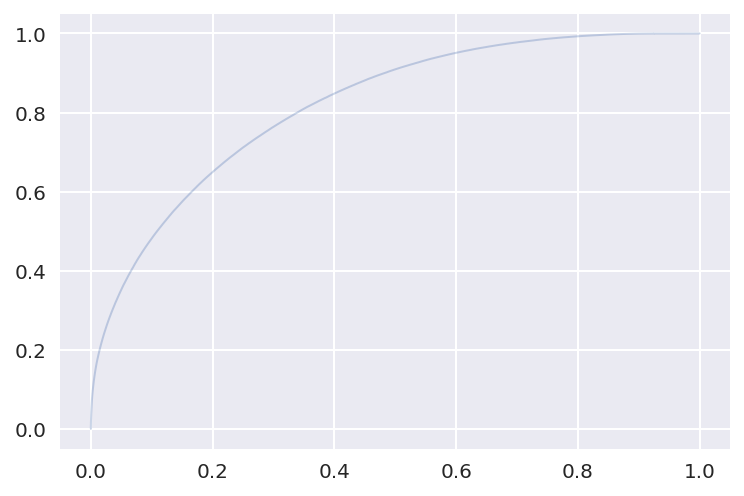

In [43]:
plt.plot(fpr, tpr, lw=1, alpha=0.3)

## Submission

In [44]:
X_test = test.drop(id_cols + [target_col, pred_col], axis=1)

In [45]:
y_test = model.predict_proba(X_test)[:,1]

In [46]:
test[target_col] = y_test

In [47]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [48]:
submission[target_col].describe()

count    484758.000000
mean          0.024702
std           0.033929
min           0.000006
25%           0.008051
50%           0.014750
75%           0.029143
max           1.000000
Name: CustomerInterest, dtype: float64

In [49]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.014927
1,c2cc6cc2a8,0.038462
2,a8e94f6344,0.006191
3,758bae1e35,0.004370
4,02ab378ee8,0.006549


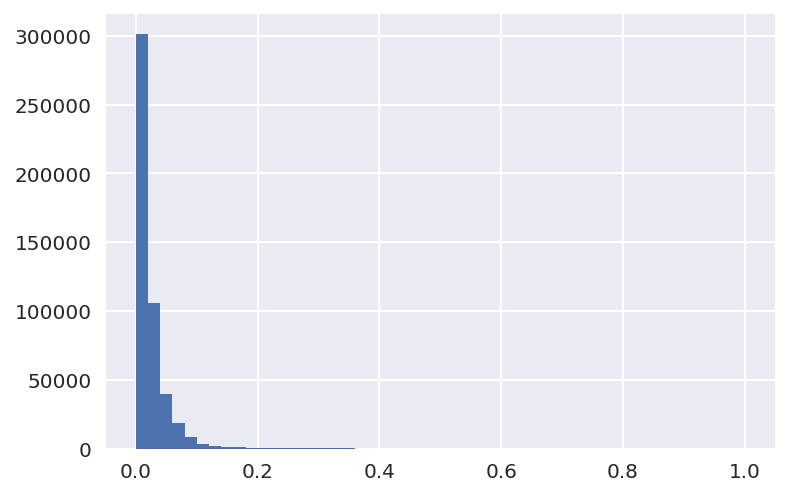

In [50]:
submission[target_col].hist(bins=50)

In [51]:
submission.to_csv(SUBMISSIONS/'JC03-27-lgbm_2017_2018_SVD_diffscounts.csv', index=False)

## Feature importance

In [52]:
from lightgbm import plot_importance

In [53]:
X_test.shape

(484758, 72)

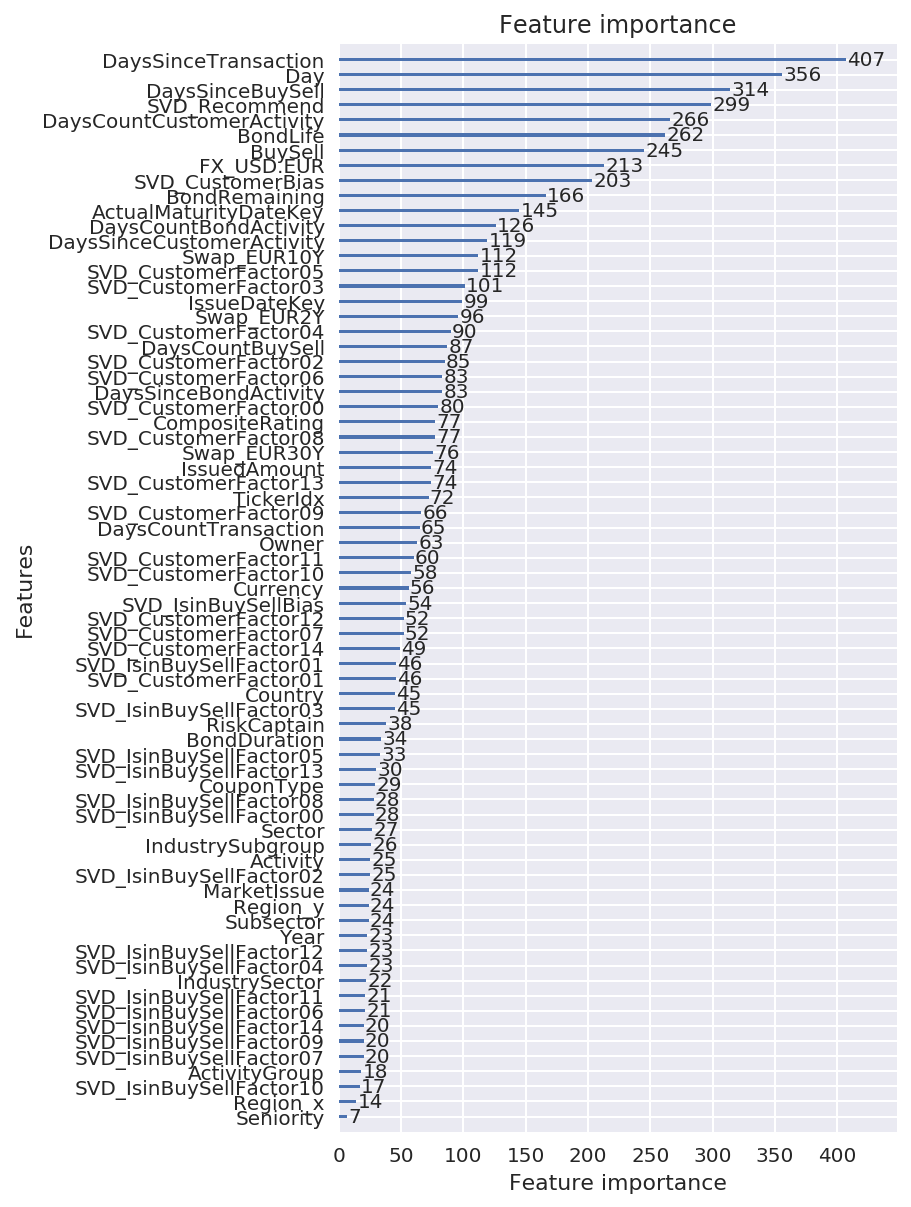

In [54]:
plot_importance(model, figsize=(5,10))